In [96]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [97]:
#importing data from yahoo finance
SPY = yf.Ticker('SPY')

In [98]:
SPY = pd.DataFrame(SPY.history(period = '10y'))

In [99]:
SPY.index = pd.to_datetime(SPY.index)
SPY.index = SPY.index.date
SPY.head()

,Close,High,Low,Open,Volume,Dividends,Stock Splits,Capital Gains
2014-06-20,NaN,NaN,NaN,NaN,0,0.937,0.0,0.0
2014-06-23,164.483185,164.625935,164.180887,164.575554,70611000,0.000,0.0,0.0
2014-06-24,163.492340,165.003828,163.307602,164.189304,96237000,0.000,0.0,0.0
2014-06-25,164.231277,164.399218,163.114456,163.148039,82782000,0.000,0.0,0.0
2014-06-26,164.113647,164.273195,163.013625,164.256397,84312000,0.000,0.0,0.0


In [100]:
SPY.dtypes

Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
Dividends        float64
Stock Splits     float64
Capital Gains    float64
dtype: object

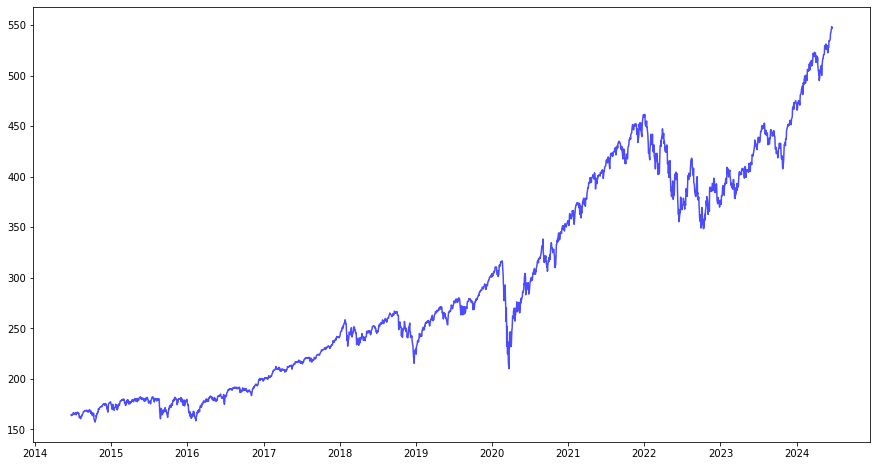

In [101]:
plt.figure(figsize=(15, 8))
plt.plot(SPY['Close'], alpha=0.7, color='blue')

In [102]:
AORD = yf.Ticker('^AORD')
HSI = yf.Ticker('^HSI')   
Nikkei = yf.Ticker('^N225') 
CAC40 = yf.Ticker('^FCHI')
DAX = yf.Ticker('^GDAXI')
SP500 = yf.Ticker('^GSPC') 
NASDAQ = yf.Ticker('^IXIC')
DJI = yf.Ticker('^DJI') 

In [103]:
#I want to us indices from other markets to create a prediction model for SPY
#Asian Market: Aord, HSI, Nikkei
#EU: CAC40, DAX
#US: S&P500, NASDAQ, DJI 
AORD = pd.DataFrame(AORD.history('10y'))  
HSI = pd.DataFrame(HSI.history('10y'))
Nikkei = pd.DataFrame(Nikkei.history('10y'))
CAC40 = pd.DataFrame(CAC40.history('10y')) 
DAX = pd.DataFrame(DAX.history('10y')) 
SP500 = pd.DataFrame(SP500.history('10y'))  
NASDAQ = pd.DataFrame(NASDAQ.history('10y'))     
DJI = pd.DataFrame(DJI.history('10y'))
#We will create a multiple linear regression model to predict the next day open price.
#Using the difference of open next day-open for SPY
#Then I am using the difference of open-open last day for the us and eu market 
#Lastly I will use the difference of the close-open prices from the asian market
#Difference between today's and yesterday's open prices for US and EU market helps me gauge how overnight changes in these markets might influence investor sentiment and trading activity in SPY at its open.


In [104]:
AORD.index = pd.to_datetime(AORD.index)
AORD.index = AORD.index.date
HSI.index = pd.to_datetime(HSI.index)
HSI.index = HSI.index.date
Nikkei.index = pd.to_datetime(Nikkei.index)
Nikkei.index = Nikkei.index.date
CAC40.index = pd.to_datetime(CAC40.index)
CAC40.index = CAC40.index.date
DAX.index = pd.to_datetime(DAX.index)
DAX.index = DAX.index.date
SP500.index = pd.to_datetime(SP500.index)
SP500.index = SP500.index.date
NASDAQ.index = pd.to_datetime(NASDAQ.index)
NASDAQ.index = NASDAQ.index.date
DJI.index = pd.to_datetime(DJI.index)
DJI.index = DJI.index.date

In [105]:
indicepanel = pd.DataFrame(index=SPY.index)
indicepanel['SPY'] = SPY['Open'].shift(-1) - SPY['Open']
indicepanel['SPY_lag1'] = indicepanel['SPY'].shift(1)
indicepanel['SP500'] = SP500['Open'] - SP500['Open'].shift(1)
indicepanel['NASDAQ'] = NASDAQ['Open'] - NASDAQ['Open'].shift(1)
indicepanel['DJI'] = DJI['Open'] - DJI['Open'].shift(1)

indicepanel['CAC40'] = CAC40['Open'] - CAC40['Open'].shift(1)
indicepanel['DAX'] = DAX['Open'] - DAX['Open'].shift(1)

indicepanel['AORD'] = AORD['Close'] - AORD['Open']
indicepanel['HSI'] = HSI['Close'] - HSI['Open']
indicepanel['Nikkei'] = Nikkei['Close'] - Nikkei['Open']

indicepanel['Price'] = SPY['Open']

In [106]:
#From our data the NaN is present 
#We can try an fill the NaN values with the values from the previous row using fill forward
indicepanel.ffill(inplace=True)  # ffill = Forward fill NaN values
indicepanel.head()

,SPY,SPY_lag1,SP500,NASDAQ,DJI,CAC40,DAX,AORD,HSI,Nikkei,Price
2014-06-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-44.799805,-5.119141,-10.179688,NaN
2014-06-23,-0.386250,NaN,NaN,NaN,NaN,-14.989746,-4.099609,31.100098,-360.449219,-50.189453,164.575554
2014-06-24,-1.041265,-0.386250,-0.950073,-1.060059,-11.880859,-10.979980,-52.760742,-17.600098,-35.279297,75.740234,164.189304
2014-06-25,1.108358,-1.041265,-12.699951,-26.080078,-116.939453,-35.180176,-54.859375,-28.300293,-68.361328,-30.629883,163.148039
2014-06-26,-0.528921,1.108358,10.619995,37.620117,49.130859,-23.580078,10.769531,60.000000,249.990234,-11.639648,164.256397


In [107]:
indicepanel = indicepanel.dropna()
indicepanel.head()

,SPY,SPY_lag1,SP500,NASDAQ,DJI,CAC40,DAX,AORD,HSI,Nikkei,Price
2014-06-24,-1.041265,-0.386250,-0.950073,-1.060059,-11.880859,-10.979980,-52.760742,-17.600098,-35.279297,75.740234,164.189304
2014-06-25,1.108358,-1.041265,-12.699951,-26.080078,-116.939453,-35.180176,-54.859375,-28.300293,-68.361328,-30.629883,163.148039
2014-06-26,-0.528921,1.108358,10.619995,37.620117,49.130859,-23.580078,10.769531,60.000000,249.990234,-11.639648,164.256397
2014-06-27,0.604557,-0.528921,-3.329956,-7.640137,-19.910156,-23.609863,-76.089844,-17.699707,33.039062,-195.750000,163.727476
2014-06-30,0.419825,0.604557,4.229980,26.570312,5.589844,-4.140137,15.389648,-47.100098,-82.468750,2.649414,164.332033


In [108]:
#cleaned our data so that with preserved continuity while having no NaN
indicepanel.shape

(2515, 11)

In [109]:
indicepanel.corr()

,SPY,SPY_lag1,SP500,NASDAQ,DJI,CAC40,DAX,AORD,HSI,Nikkei,Price
SPY,1.000000,-0.050495,-0.020282,-0.030006,-0.024173,-0.037667,-0.051619,-0.013986,-0.072396,0.024794,0.012323
SPY_lag1,-0.050495,1.000000,0.935813,0.926307,0.825410,0.536726,0.530332,0.517102,0.146325,0.250541,0.043295
SP500,-0.020282,0.935813,1.000000,0.886091,0.907616,0.573849,0.560016,0.506571,0.076954,0.217397,0.043216
NASDAQ,-0.030006,0.926307,0.886091,1.000000,0.685876,0.456631,0.460666,0.433192,0.148563,0.224998,0.032359
DJI,-0.024173,0.825410,0.907616,0.685876,1.000000,0.595564,0.576657,0.509491,0.050975,0.203068,0.021705
CAC40,-0.037667,0.536726,0.573849,0.456631,0.595564,1.000000,0.891222,0.617438,0.211197,0.363850,0.017569
DAX,-0.051619,0.530332,0.560016,0.460666,0.576657,0.891222,1.000000,0.606956,0.209411,0.378376,0.021128
AORD,-0.013986,0.517102,0.506571,0.433192,0.509491,0.617438,0.606956,1.000000,0.156362,0.325046,0.014522
HSI,-0.072396,0.146325,0.076954,0.148563,0.050975,0.211197,0.209411,0.156362,1.000000,0.234272,0.001627
Nikkei,0.024794,0.250541,0.217397,0.224998,0.203068,0.363850,0.378376,0.325046,0.234272,1.000000,0.031832


In [110]:
indicepanel.to_csv("D:\downloads\Data\indicepanel.csv")

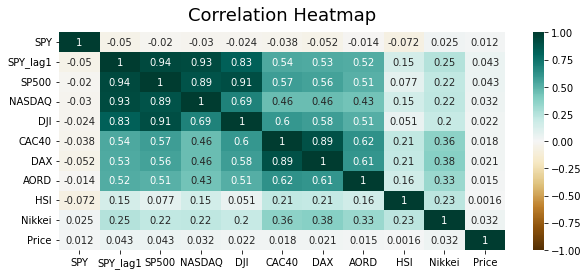

In [112]:
#Creating a corr matrix heatmap
import seaborn as sns

plt.figure(figsize = (10, 4))
heatmap = sns.heatmap(indicepanel.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

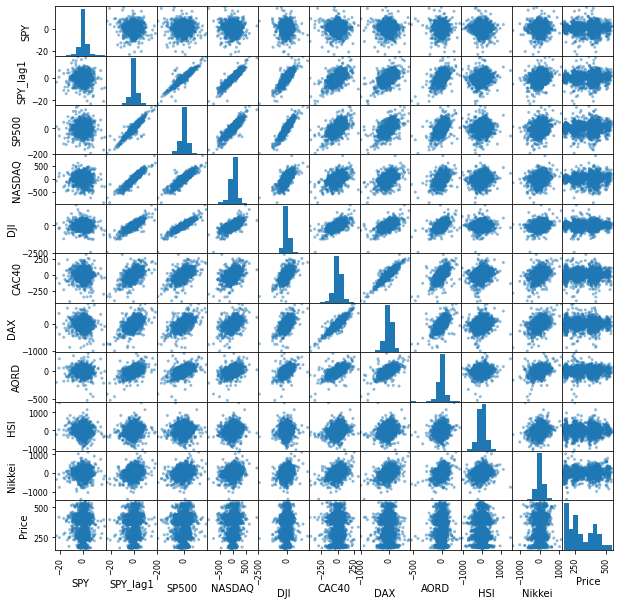

In [113]:
#There are no signs of the stock being correlated with SPY but the lag value provides some correlation with the other stocks.
#Could suggest that the lag prices of SPY corresponds to the increase in the other stock values.
from pandas.plotting import scatter_matrix
scatter_matrix = scatter_matrix(indicepanel, figsize=(10,10))

In [130]:
start = dt.date(2020, 1, 1)
end = dt.date(2022, 6, 13)

training_data = indicepanel.loc[start:end]

training_data.tail()

,SPY,SPY_lag1,SP500,NASDAQ,DJI,CAC40,DAX,AORD,HSI,Nikkei,Price
2022-06-07,5.651008,-6.474932,-38.250000,-274.520508,-249.007812,-10.659668,-7.570312,-114.500000,-45.810547,-40.839844,395.572628
2022-06-08,-4.449081,5.651008,50.649902,221.470703,304.039062,-5.610352,26.480469,28.399902,225.699219,134.029297,401.223635
2022-06-09,-14.016066,-4.449081,-45.470215,-130.810547,-258.449219,-104.969727,-231.190430,-106.600098,-252.478516,57.179688,396.774555
2022-06-10,-14.568654,-14.016066,-127.260010,-472.589844,-775.101562,-96.169922,-254.559570,-95.199707,283.679688,-172.060547,382.758489
2022-06-13,-2.907929,-14.568654,-136.239990,-557.030273,-908.609375,-228.360352,-545.560547,-95.199707,-94.949219,-382.220703,368.189835


In [131]:
num_rows = training_data.shape[0]
print(f"Number of rows in training_data: {num_rows}")

Number of rows in training_data: 617


In [132]:
#we are using this dataset to test our accuracy with already known data
test_start = dt.date(2022, 1, 1)
test_end = dt.date(2024, 6, 17)

testing_data = indicepanel.loc[test_start:test_end]
testing_data.tail()


,SPY,SPY_lag1,SP500,NASDAQ,DJI,CAC40,DAX,AORD,HSI,Nikkei,Price
2024-06-11,7.559998,0.890015,11.779785,76.970703,10.812500,108.569824,-52.480469,-106.899902,13.220703,-40.800781,534.070007
2024-06-12,1.520020,7.559998,56.129883,341.730469,154.937500,-107.319824,-129.330078,-42.699707,-94.560547,11.562500,541.630005
2024-06-13,-2.270020,1.520020,32.800293,213.119141,-273.527344,41.600098,263.490234,39.399902,8.500000,-461.589844,543.150024
2024-06-14,1.200012,-2.270020,-17.850098,-94.089844,-148.730469,-169.870117,-364.330078,-27.700195,-86.291016,226.988281,540.880005
2024-06-17,5.079956,1.200012,7.029785,76.121094,36.789062,-146.470215,-259.449219,-31.199707,87.250000,-338.539062,542.080017


In [133]:
num_rows = testing_data.shape[0]
print(f"Number of rows in testing_data: {num_rows}")

Number of rows in testing_data: 617


In [135]:
print(training_data.shape, testing_data.shape)

(617, 11) (617, 11)


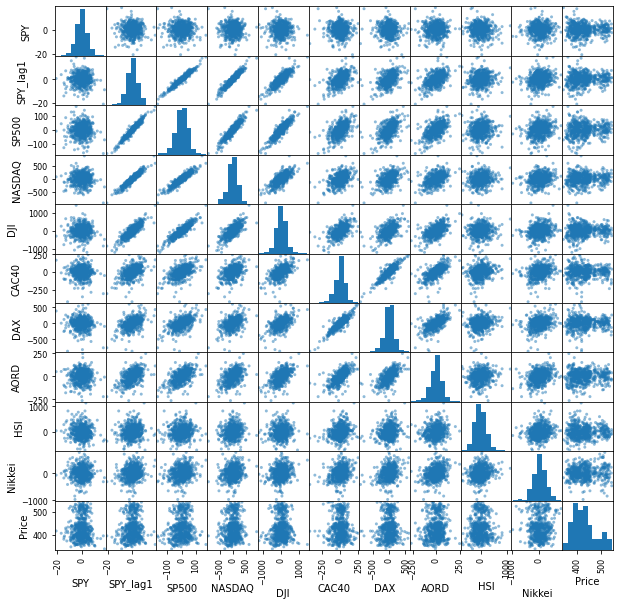

In [136]:
from pandas.plotting import scatter_matrix
scatter_matrix = scatter_matrix(testing_data, figsize=(10,10))

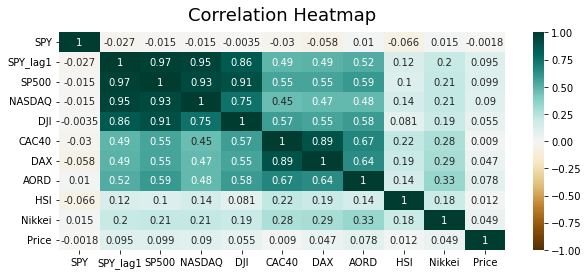

In [137]:
plt.figure(figsize = (10, 4))
heatmap = sns.heatmap(testing_data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

In [154]:
#I want to be weary of multicolinearity when building my multi linear regression
#therefore I will choose predictors that are relevant and less correlated to each other
from sklearn.linear_model import LinearRegression
X_train = training_data[['HSI','DAX', 'CAC40','SPY_lag1']]
Y_train = training_data['SPY']

model = LinearRegression()
model.fit(X_train, Y_train)

coefficients = model.coef_
intercept = model.intercept_

print(model.intercept_)
print(model.coef_)

0.06106525112776482
[-0.00202473 -0.00178417  0.0031403  -0.01903237]


In [175]:
X_test = testing_data[['HSI','DAX', 'CAC40','SPY_lag1']]
Y_test = testing_data['SPY']
predictions = model.predict(X_test)

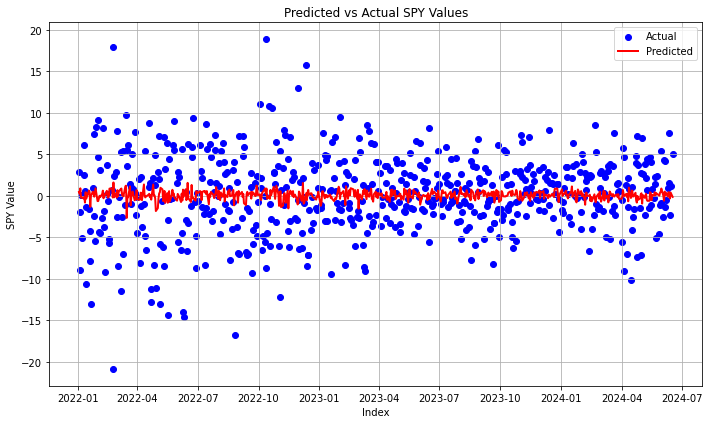

In [179]:
plt.figure(figsize=(10, 6))

# Scatter plot of actual values
plt.scatter(testing_data.index, Y_test, color='blue', label='Actual')

# Line plot of predictions
plt.plot(testing_data.index, predictions, color='red', linewidth=2, label='Predicted')

plt.title('Predicted vs Actual SPY Values')
plt.xlabel('Index')
plt.ylabel('SPY Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [180]:
print(predictions)

[ 4.67646938e-01  2.52547864e-01  8.97553739e-01 -2.30113137e-01
 -1.97126310e-01 -3.23928468e-01 -1.39788521e-01 -8.14439688e-01
  4.23609169e-01 -3.42394628e-01  6.26881494e-01  4.38807700e-01
 -1.33693299e+00  9.19410928e-03  5.01908676e-01  2.46807380e-01
 -1.12733786e-01  4.07372800e-01  8.97901098e-01 -6.38058867e-01
 -6.36639332e-01 -3.06026113e-01 -2.80710789e-03 -1.48426996e-01
  2.06923593e-01  6.17869581e-01 -2.98841858e-01  1.33445278e-01
  2.49576394e-02  5.96517535e-01  6.12128467e-02 -2.15850748e-01
 -5.21409231e-02  8.64196288e-01  8.75385282e-01 -2.05769491e-01
  1.60652106e+00 -1.87191400e-01  3.21839286e-01 -2.08588998e-01
  6.78050313e-01 -2.56231689e-02  5.03202646e-01  8.08591320e-01
  8.73638212e-01  8.88773215e-02  2.39186880e-01 -7.60656834e-02
  1.14172222e+00  1.21818576e+00 -2.67220390e+00 -1.86098744e-01
 -1.94680617e-01  1.12588706e+00 -1.15483053e+00 -1.12321020e-01
  3.43255906e-01  5.12769919e-01 -5.36508537e-01 -4.86216694e-01
 -1.20932459e-01  6.73688

In [181]:
from sklearn.metrics import mean_squared_error, r2_score

RMSE = np.sqrt(mean_squared_error(Y_test, predictions))
R2 = r2_score(Y_test, predictions)

print(f"RMSE: {RMSE}")
print(f"R-squared: {R2}")

RMSE: 4.681638692056964
R-squared: 0.006017160430693891


In [182]:
RMSE = np.sqrt(mean_squared_error(Y_train, predictions))
R2 = r2_score(Y_train, predictions)

print(f"RMSE: {RMSE}")
print(f"R-squared: {R2}")

RMSE: 4.819093573147469
R-squared: -0.0250367889391081


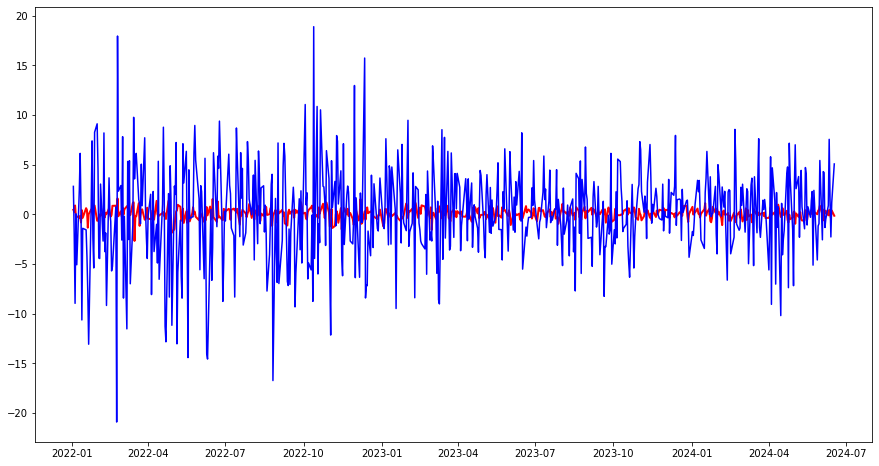

In [186]:
#negative R square in the training indicates the test has preformed better and our model is not overfitted.